# Feature extraction

## SIFT / BoW / MHI

In [2]:
import cv2

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

matcher = cv2.FlannBasedMatcher(index_params,search_params)
sift = cv2.SIFT_create(nfeatures=20)

cluster_size = 20
tc = (cv2.TERM_CRITERIA_MAX_ITER, 10, 0.001)
retries = 3
flags = cv2.KMEANS_PP_CENTERS;

bow_trainer = cv2.BOWKMeansTrainer(cluster_size, tc, retries, flags)
bow_descriptor_extractor = cv2.BOWImgDescriptorExtractor(sift, matcher)

In [3]:
import glob

jab_depth_files = [file for file in glob.glob('./numpy_data_arrays/jab/*depth.npz')]
cross_depth_files = [file for file in glob.glob('./numpy_data_arrays/cross/*depth.npz')]
left_hook_depth_files = [file for file in glob.glob('./numpy_data_arrays/left_hook/*depth.npz')]
right_hook_depth_files = [file for file in glob.glob('./numpy_data_arrays/right_hook/*depth.npz')]
random_depth_files = [file for file in glob.glob('./numpy_data_arrays/random/*depth.npz')]

### MHI

In [4]:
import numpy as np

THRESHOLD_VALUE = 5
MHI_DURATION = 2

def generate_mhi(frames):
    number_of_frames = frames.shape[0]
    height = frames.shape[1]
    width = frames.shape[2]
    SAMHI_10 = np.zeros((height, width), dtype=np.float32)

    for i in range(1, number_of_frames):
        frame = frames[i]
        frame[frame > 2200] = 0

        image_binary = frame.astype(np.uint8)

        num = 2
        image_binary_prev = np.zeros((height, width), dtype=np.uint8)
        difference = np.zeros((height, width), dtype=np.uint8)

        if i == 1:
            image_binary_prev = image_binary
        elif (i % num) == 0:
            difference = cv2.absdiff(image_binary_prev, image_binary)
            image_binary_prev = image_binary

        if i == num + 1:
            _, image_binary_diff_5 = cv2.threshold(difference, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
            SAMHI_10 = cv2.motempl.updateMotionHistory(image_binary_diff_5, SAMHI_10, i / number_of_frames, MHI_DURATION)

        if (i > num + 1 and i % num == 0):
            _, image_binary_diff_5 = cv2.threshold(difference, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
            SAMHI_10 = cv2.motempl.updateMotionHistory(image_binary_diff_5, SAMHI_10, i / number_of_frames, MHI_DURATION)


    SAMHI_10 = cv2.convertScaleAbs(SAMHI_10, alpha=255, beta=0)
    return SAMHI_10

### SIFT

In [5]:
motion_image = None
all_descriptors = []

for file in jab_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

for file in cross_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

for file in left_hook_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

for file in right_hook_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

# for file in random_depth_files:
#     file_name = file.split("\\")[-1].split('.')[0]
#     depth_data = np.load(file)
#     depth_frames = depth_data['arr_0']
#     samhi = generate_mhi(depth_frames)
#     keypoint, descriptors = sift.detectAndCompute(samhi, None)

#     if descriptors is not None and descriptors.shape[0] > 0:
#         all_descriptors.append(descriptors)
#         bow_trainer.add(descriptors)
#     keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

    # cv2.imshow("MHI", samhi)
    # cv2.imshow("Keypoint", keyP1)
    # if descriptors is not None and descriptors.shape[0] > 0:
    #     cv2.imshow("Features", descriptors)

    # bow_descriptor = bow_descriptor_extractor.compute(samhi, keypoint)

    # dataset_descriptors.append(bow_descriptor)
    # dataset_labels.append(1)

    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
dictionary = bow_trainer.cluster()

### BoW

In [6]:
bow_descriptor_extractor.setVocabulary(dictionary)

In [7]:
dataset_descriptors = []
dataset_labels = []

for file in jab_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

    # cv2.imshow("MHI", samhi)
    # cv2.imshow("Keypoint", keyP1)
    # if descriptors is not None and descriptors.shape[0] > 0:
    #     cv2.imshow("Features", descriptors)

    bow_descriptor = bow_descriptor_extractor.compute(samhi, keypoint)
    if bow_descriptor is not None and descriptors.shape[0] > 0:
        dataset_descriptors.append(bow_descriptor)
        dataset_labels.append("jab")
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

for file in cross_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

    # cv2.imshow("MHI", samhi)
    # cv2.imshow("Keypoint", keyP1)
    # if descriptors is not None and descriptors.shape[0] > 0:
    #     cv2.imshow("Features", descriptors)

    bow_descriptor = bow_descriptor_extractor.compute(samhi, keypoint)
    if bow_descriptor is not None and descriptors.shape[0] > 0:
        dataset_descriptors.append(bow_descriptor)
        dataset_labels.append("cross")

for file in left_hook_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

    # cv2.imshow("MHI", samhi)
    # cv2.imshow("Keypoint", keyP1)
    # if descriptors is not None and descriptors.shape[0] > 0:
    #     cv2.imshow("Features", descriptors)

    bow_descriptor = bow_descriptor_extractor.compute(samhi, keypoint)
    if bow_descriptor is not None and descriptors.shape[0] > 0:
        dataset_descriptors.append(bow_descriptor)
        dataset_labels.append("left_hook")

for file in right_hook_depth_files:
    file_name = file.split("\\")[-1].split('.')[0]
    depth_data = np.load(file)
    depth_frames = depth_data['arr_0']
    samhi = generate_mhi(depth_frames)
    keypoint, descriptors = sift.detectAndCompute(samhi, None)

    if descriptors is not None and descriptors.shape[0] > 0:
        all_descriptors.append(descriptors)
        bow_trainer.add(descriptors)
    keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

    # cv2.imshow("MHI", samhi)
    # cv2.imshow("Keypoint", keyP1)
    # if descriptors is not None and descriptors.shape[0] > 0:
    #     cv2.imshow("Features", descriptors)

    bow_descriptor = bow_descriptor_extractor.compute(samhi, keypoint)
    if bow_descriptor is not None and descriptors.shape[0] > 0:
        dataset_descriptors.append(bow_descriptor)
        dataset_labels.append("right_hook")

# for file in random_depth_files:
#     file_name = file.split("\\")[-1].split('.')[0]
#     depth_data = np.load(file)
#     depth_frames = depth_data['arr_0']
#     samhi = generate_mhi(depth_frames)
#     keypoint, descriptors = sift.detectAndCompute(samhi, None)

#     if descriptors is not None and descriptors.shape[0] > 0:
#         all_descriptors.append(descriptors)
#         bow_trainer.add(descriptors)
#     keyP1 = cv2.drawKeypoints(samhi,keypoint, None,(255, 255, 255), 0)

#     # cv2.imshow("MHI", samhi)
#     # cv2.imshow("Keypoint", keyP1)
#     # if descriptors is not None and descriptors.shape[0] > 0:
#     #     cv2.imshow("Features", descriptors)

#     bow_descriptor = bow_descriptor_extractor.compute(samhi, keypoint)
#     if bow_descriptor is not None and descriptors.shape[0] > 0:
#         dataset_descriptors.append(bow_descriptor)
#         dataset_labels.append("random")

# Classification

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

flattened_descriptors = []
for dataset_descriptor in dataset_descriptors:
    flattened_descriptors.append(dataset_descriptor.flatten())

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(dataset_labels)

X_train, X_test, y_train, y_test = train_test_split(flattened_descriptors, encoded_labels, test_size=0.3)

classes = label_encoder.classes_

In [9]:
from sklearn.utils import shuffle

shuffled_X, shuffled_y = shuffle(np.array(flattened_descriptors), np.array(encoded_labels))

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

def run_kfolds(model, x, y, splits):
    kf = KFold(n_splits=splits, shuffle=True)
    scores = cross_val_score(model, x, y, cv=kf, scoring="accuracy")
    predict = cross_val_predict(model, x, y, cv=kf)
    return scores, predict

## SVM

Accuracy: 0.6333333333333333
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.86      0.63         7
           1       0.57      0.67      0.62         6
           2       0.67      0.50      0.57         8
           3       1.00      0.56      0.71         9

    accuracy                           0.63        30
   macro avg       0.68      0.64      0.63        30
weighted avg       0.71      0.63      0.64        30



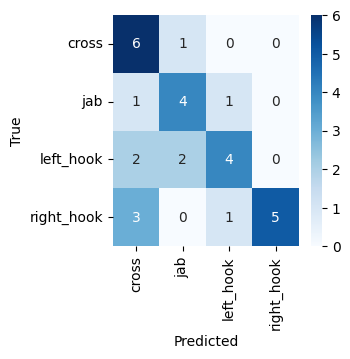

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

SVM = SVC(kernel='rbf', gamma=0.50625000000000009, C=312.5)

X_train = np.array(X_train)
y_train = np.array(y_train)

SVM.fit(X_train, y_train)

X_test = np.array(X_test)
n_samples = X_test.shape[0]
X_test = X_test.reshape(n_samples, -1)

y_test = np.array(y_test)

# Make predictions on the test data
y_pred = SVM.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
svm_report = classification_report(y_test, y_pred)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("SVM Classification Report:")
print(svm_report)

cm = confusion_matrix(y_test, y_pred)
# Get the class labels from LabelEncoder
class_labels = label_encoder.classes_

# Display the confusion matrix as a heatmap
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Cross validation

Accuracy: 0.48
SVM Cross Validation Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.48      0.45        25
           1       0.48      0.48      0.48        25
           2       0.58      0.56      0.57        25
           3       0.43      0.40      0.42        25

    accuracy                           0.48       100
   macro avg       0.48      0.48      0.48       100
weighted avg       0.48      0.48      0.48       100



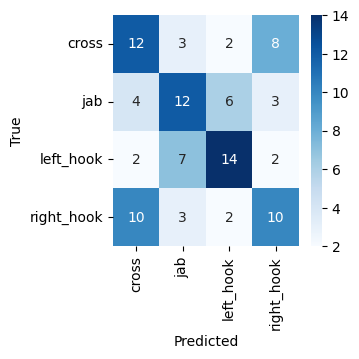

In [12]:
from sklearn.svm import SVC

SVM = SVC(kernel='rbf', gamma=0.50625000000000009, C=312.5)
svm_scores, svm_predicts = run_kfolds(SVM, shuffled_X, shuffled_y, 5)

# Calculate evaluation metrics
accuracy = accuracy_score(shuffled_y, svm_predicts)
svm_report = classification_report(shuffled_y, svm_predicts)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("SVM Cross Validation Classification Report:")
print(svm_report)

cm = confusion_matrix(shuffled_y, svm_predicts)
# Get the class labels from LabelEncoder
class_labels = label_encoder.classes_

# Display the confusion matrix as a heatmap
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Naive Bayes

Accuracy: 0.4
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.43      0.38         7
           1       0.40      0.33      0.36         6
           2       0.43      0.38      0.40         8
           3       0.44      0.44      0.44         9

    accuracy                           0.40        30
   macro avg       0.40      0.40      0.40        30
weighted avg       0.41      0.40      0.40        30



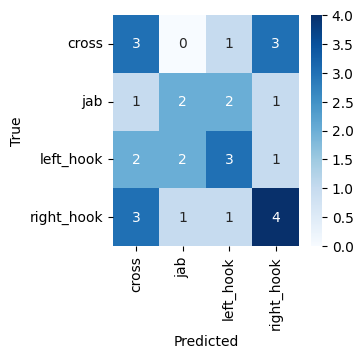

In [13]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()

NB.fit(X_train, y_train)
y_pred_nb = NB.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_nb)
svm_report = classification_report(y_test, y_pred_nb)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("Naive Bayes Classification Report:")
print(svm_report)

cm = confusion_matrix(y_test, y_pred_nb)
# Get the class labels from LabelEncoder
class_labels = label_encoder.classes_

# Display the confusion matrix as a heatmap
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Cross validation

Accuracy: 0.5
Naive-Bayes Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.56      0.57        25
           1       0.50      0.40      0.44        25
           2       0.45      0.52      0.48        25
           3       0.48      0.52      0.50        25

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.50       100
weighted avg       0.50      0.50      0.50       100



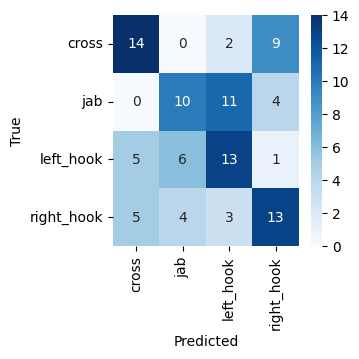

In [14]:
NB1 = GaussianNB()

scores, predicts = run_kfolds(NB1, shuffled_X, shuffled_y, 5)

# Calculate evaluation metrics
accuracy = accuracy_score(shuffled_y, predicts)
svm_report = classification_report(shuffled_y, predicts)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("Naive-Bayes Cross-Validation Classification Report:")
print(svm_report)

cm = confusion_matrix(shuffled_y, predicts)
# Get the class labels from LabelEncoder
class_labels = label_encoder.classes_

# Display the confusion matrix as a heatmap
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Random Forest

### Cross validation

Accuracy: 0.46
Random Forest Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.48      0.46        25
           1       0.50      0.36      0.42        25
           2       0.45      0.52      0.48        25
           3       0.46      0.48      0.47        25

    accuracy                           0.46       100
   macro avg       0.46      0.46      0.46       100
weighted avg       0.46      0.46      0.46       100



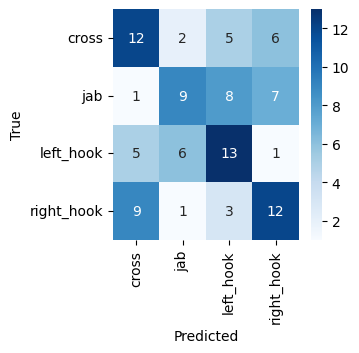

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)

scores, predicts = run_kfolds(rf, shuffled_X, shuffled_y, 5)

# Calculate evaluation metrics
accuracy = accuracy_score(shuffled_y, predicts)
rf_report = classification_report(shuffled_y, predicts)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("Random Forest Cross-Validation Classification Report:")
print(rf_report)

cm = confusion_matrix(shuffled_y, predicts)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(3, 3))
class_labels = label_encoder.classes_
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' , xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Multi-layer Perceptron

### Cross validation

Accuracy: 0.55
MLP Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.64      0.58        25
           1       0.48      0.52      0.50        25
           2       0.61      0.56      0.58        25
           3       0.60      0.48      0.53        25

    accuracy                           0.55       100
   macro avg       0.56      0.55      0.55       100
weighted avg       0.56      0.55      0.55       100



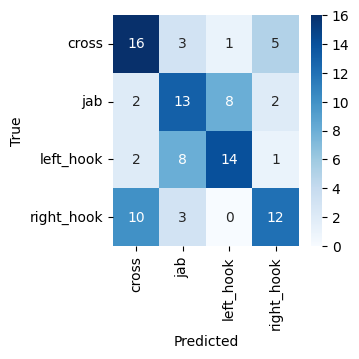

In [16]:
#import the classifier
from sklearn.neural_network import MLPClassifier

# initialize the classifier
#MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
MLP = MLPClassifier(max_iter=10000)
scores, predicts = run_kfolds(MLP, shuffled_X, shuffled_y, 5)

# Calculate evaluation metrics
accuracy = accuracy_score(shuffled_y, predicts)
mlp_report = classification_report(shuffled_y, predicts)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("MLP Cross-Validation Classification Report:")
print(mlp_report)

cm = confusion_matrix(shuffled_y, predicts)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(3, 3))
class_labels = label_encoder.classes_
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' , xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
